# Title : Practical Lab 2: Multivariate Linear Regression and Non-Parametric Models.
* Student Name : Akshata Madhav.
* Student ID : 8944328
* Section 2

# Load Scikit-Learn diabetes dataset

# 1. Get the data.

In [88]:
# load diabetes dataset
from sklearn.datasets import load_diabetes
diabetes = load_diabetes(as_frame=True)
df = diabetes.frame
X, y = diabetes.data, diabetes.target


# 2. Frame the Problem. Notice that the dependent variable of diabetes progression, namely "disease progression one year after baseline".

The goal of the diabetes dataset we are working with is to recreate or forecast the evolution of the illness one year from the baseline readings.This is a regression problem because the target variable, disease progression, is continuous. The objective is to create a machine learning model that, given the initial measurements of new patients, can reliably forecast the value of illness progression. The model will forecast the course of the disease one year after the baseline based on a variety of factors that it receives as input.



# 3. EDA - Describe the data, explore it, and provide insights about it. This should include at least: statistics, scatter plots histograms, a correlation matrix, and concise and relevant insights (4 point).

In [89]:
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


The features appear to be normalized, as their means are close to zero and their standard deviations are similar. This suggests the features have been preprocessed to have a mean of zero and unit variance.The BMI values range from -0.09 to 0.17, indicating that while normalized, the original values might have had a positive skew

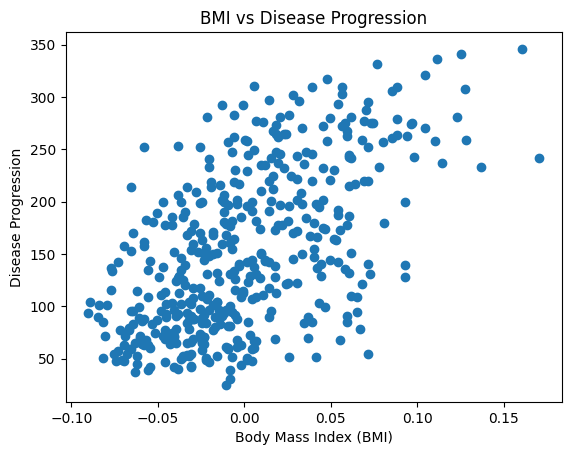

In [90]:
import matplotlib.pyplot as plt

# Example: Scatter plot for one feature vs. target
plt.scatter(df['bmi'], df['target'])
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Disease Progression')
plt.title('BMI vs Disease Progression')
plt.show()


From this scatterplot we can observe that as BMI increases, the disease progression also tends to increase. There is a positive correlation, meaning that individuals with higher BMI tend to have higher diabetes progression. 

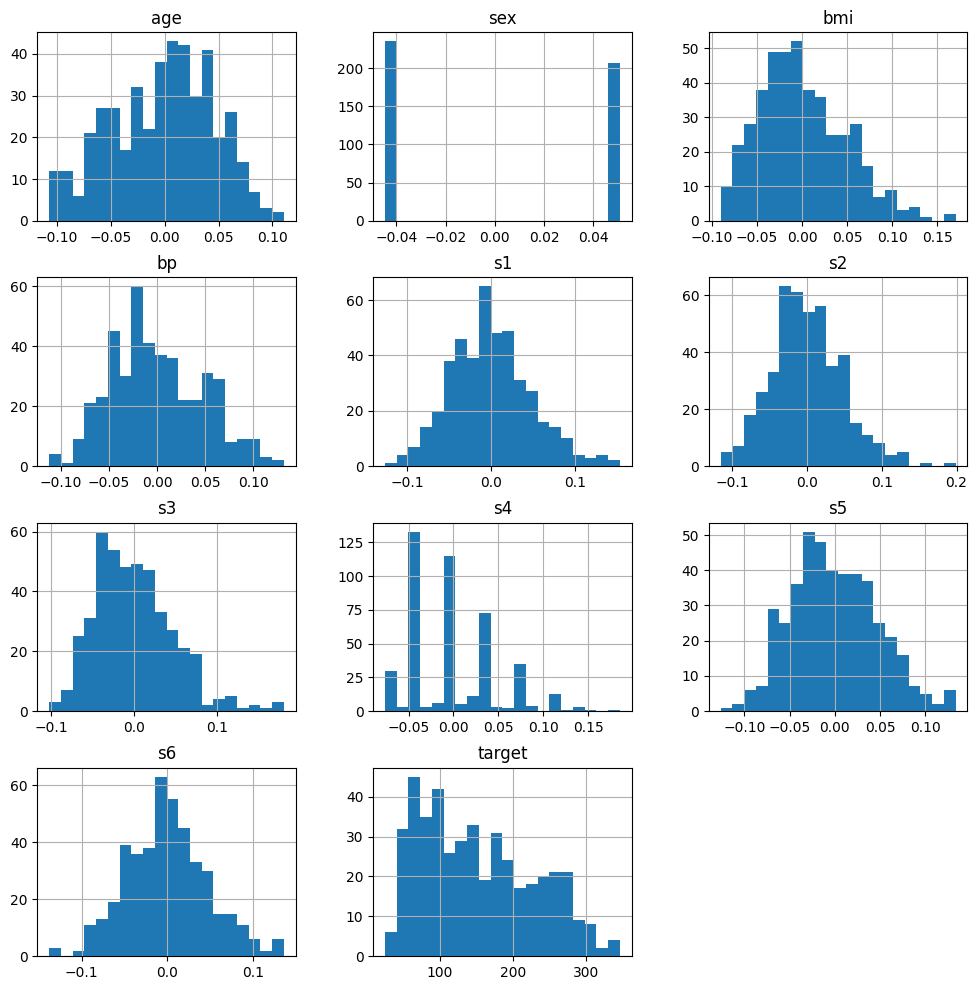

In [91]:
histogram_data = df
histogram_data.hist(figsize=(12, 12), bins=20)
plt.show()

From observation of histogram we can see that most of our data is normal distributed except for bmi which seems to be positively skewed. Also has age increases the value of bmi also increases. While for the histogram of sex data we see two different peaks suggesting group of values for both genders male and female.

# 4. Clean the data if needed, and explain your reasoning for your reader (1 point)

In [92]:
missing_values = df.isnull().sum() 
print(missing_values)

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


Here we can checking for any null values in each column. The output suggests that we have none null values in our dataset.

# 5. Split the dataset to a train (75%) and validation set (10%), and test set (15%).

In [93]:
from sklearn.model_selection import train_test_split
train_data, temp_data = train_test_split(df, test_size=0.25, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.6, random_state=42)

bmi_train = train_data[['bmi']]
bmi_val = validation_data[['bmi']]
bmi_test = test_data[['bmi']]

target_train = train_data['target']
target_val = validation_data['target']
target_test = test_data['target']


We are splitting our data into 3 different categories training, validation and test dataset. 
* The test_size=0.25 parameter indicates that 25% of the data will be allocated to temp_data, while 75% will be used for training. The random_state=42 ensures that the split is reproducible, meaning that the same split will occur each time the code is run.
* The temporary data is then divided into datasets for testing and validation. In this case, test_size=0.6 indicates that 40% of temp_data will be assigned to validation_data and 60% will become test_data. As a result, each of the test and validation sets gets 30% of the original data.


# 6. Models: a univariate polynomial regression on the BMI feature versus the "disease progression one year after baseline" - from degree 0 to 5 (6 models) (1.5 point)

In [94]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

result_metrics = {'Degree': [], 'R-Squared (Train)': [], 'R-Squared (Val)': [], 'MAE (Train)': [],
            'MAE (Val)': [], 'MAPE (Train)': [], 'MAPE (Val)': []}
models = []
for degree in range(6):
    poly = PolynomialFeatures(degree=degree)
    bmi_train_poly = poly.fit_transform(bmi_train)
    bmi_val_poly = poly.transform(bmi_val)
    
    
    model = LinearRegression() # Fit linear regression model
    model.fit(bmi_train_poly, target_train) # training the model 
    models.append((model, poly))
    
   
    train_pred = model.predict(bmi_train_poly)  # Prediction on training and validation sets
    val_pred = model.predict(bmi_val_poly)
    
    
    r2_train = r2_score(target_train, train_pred) # Calculate evaluation metrics
    r2_val = r2_score(target_val, val_pred)
    mae_train = mean_absolute_error(target_train, train_pred)
    mae_val = mean_absolute_error(target_val, val_pred)
    mape_train = mean_absolute_percentage_error(target_train, train_pred)
    mape_val = mean_absolute_percentage_error(target_val, val_pred)
    
   
    result_metrics['Degree'].append(degree)  # Storing results
    result_metrics['R-Squared (Train)'].append(r2_train)
    result_metrics['R-Squared (Val)'].append(r2_val)
    result_metrics['MAE (Train)'].append(mae_train)
    result_metrics['MAE (Val)'].append(mae_val)
    result_metrics['MAPE (Train)'].append(mape_train)
    result_metrics['MAPE (Val)'].append(mape_val)


results_df = pd.DataFrame(result_metrics)
display(results_df)


,Degree,R-Squared (Train),R-Squared (Val),MAE (Train),MAE (Val),MAPE (Train),MAPE (Val)
0,0,0.000000,-0.106957,66.201641,66.057059,0.628267,0.712639
1,1,0.349672,0.331264,52.287739,47.208472,0.483629,0.470600
2,2,0.350764,0.331631,52.207314,47.213700,0.482985,0.472397
3,3,0.350774,0.331638,52.198968,47.185414,0.482807,0.472227
4,4,0.353014,0.340758,52.092653,46.090118,0.480533,0.460503
5,5,0.354100,0.349881,52.059191,45.462121,0.480040,0.451753


To store the evaluation metrics for every polynomial regression degree, we create a dictionary called result_metrics. To keep track of the fitted models and the associated polynomial transformations, an empty list models is also created.We are using a for loop that iterates through polynomial degrees from 0 to 5 for each degree.


As the degree increases the value of r2 also increase but the value of mae and mape decreases. 

# Step 8 : Identify the best model based on the table above.

* R-Squared(Validation): Higher values indicate a better fit. The best R-squared on validation is 0.349881 at Degree 5.

* MAE (Validation): Lower values indicate better performance. The lowest MAE on validation is 45.462121 at Degree 5.

* MAPE (Validation): Again, lower values indicate better performance. The lowest MAPE on validation is 45.175275 at Degree 5.

* Given that Degree 5 has the best R-squared, MAE, and MAPE on the validation set, it appears to be the best model among those presented.

## Step 9 : Run the chosen model on the test set and provide results (R-Squared, MAPE, MAE) (1 point).

In [95]:
chosen = results_df.loc[results_df['R-Squared (Val)'].idxmax(), 'Degree']
poly = PolynomialFeatures(degree=int(chosen))
X_poly_train = poly.fit_transform(bmi_train)
X_poly_test = poly.transform(bmi_test)

model = LinearRegression() 
model.fit(X_poly_train, target_train)
y_test_pred = model.predict(X_poly_test) # Prediction on test set

r2_test = r2_score(target_test, y_test_pred)
mae_test = mean_absolute_error(target_test, y_test_pred)
mape_test = mean_absolute_percentage_error(target_test, y_test_pred)

print(f"Test Results for Degree {chosen} - R2: {r2_test}, MAE: {mae_test}, MAPE: {mape_test}")

Test Results for Degree 5 - R2: 0.26669658449530775, MAE: 51.75025709277397, MAPE: 0.4302671323305443


If we compare our results from train and validation set with our test set, we see that the r2 has lowest variance.Similarly the value of mape is low indicating that our model is off by 43.30%.

# 10. Plot a graph of the train, validation and test data points, and the fit of the chosen model over each of them (1 point).

d:\College Files\AAIML\CSCN8010\Classical_ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


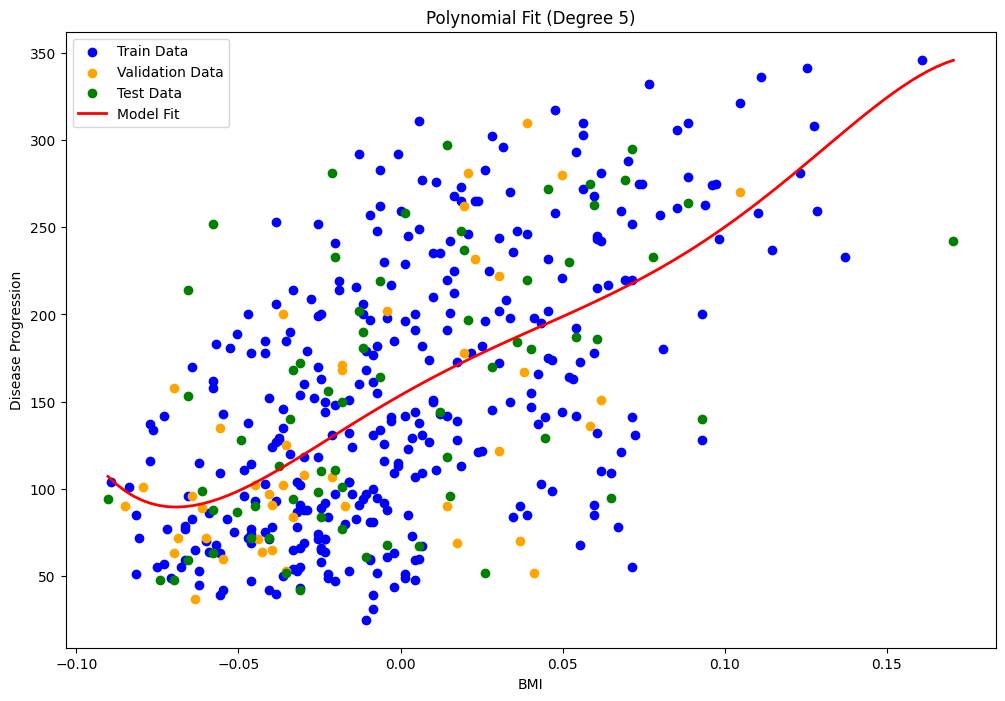

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(bmi_train, target_train, color='blue', label='Train Data')
plt.scatter(bmi_val, target_val, color='orange', label='Validation Data')
plt.scatter(bmi_test, target_test, color='green', label='Test Data')

# Create a range of values for BMI for plotting the fit
bmi_range = np.linspace(df['bmi'].min(), df['bmi'].max(), 100).reshape(-1, 1)
y_fit = model.predict(poly.transform(bmi_range))
plt.plot(bmi_range, y_fit, color='red', label='Model Fit', linewidth=2)

plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title(f'Polynomial Fit (Degree {chosen})')
plt.legend()
plt.show()


* The data trend is represented by the curve, which shows that illness progression often rises with BMI. But the curve also exhibits some non-linearity, suggesting that there may be a more complex pattern at effect here instead of a just linear relationship between BMI and the progression of the disease.
* The model attempts to capture the upward trend in the data, where disease progression increases with higher BMI. However, the spread of data points shows a large amount of variance, meaning that the relationship between BMI and disease progression is not perfectly predictable with this feature alone.

# 11. Write down the equation of the best model (with a two decimal digit precision, assuming it's sufficient) (1 point).

In [97]:
coefficients = model.coef_
intercept = model.intercept_

equation = " + ".join([f"{coef:.2f}*x^{i}" for i, coef in enumerate(coefficients)])
print(f"Equation: y = {intercept:.2f} + {equation}")


Equation: y = 153.65 + 0.00*x^0 + 1059.89*x^1 + -3824.15*x^2 + -16770.23*x^3 + 753722.52*x^4 + -2993716.57*x^5


# 12. Calculate the expected diabetes progression for a BMI value of your choice using `model.perdict()` for that value (0.5 point).

In [98]:
bmi_value = 23  # Example BMI value
expected_progression = model.predict(poly.transform([[bmi_value]]))
print(f"Expected progression for BMI {bmi_value}: {expected_progression[0]:.2f}")


Expected progression for BMI 23: -19057870289782.24


d:\College Files\AAIML\CSCN8010\Classical_ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


# 13.How many trainable parameters are we fitting for each of the models? Explain these values. One way is to use sklearn function `get_feature_names_out()`(1 point)

In [99]:
feature_names = poly.get_feature_names_out(input_features=['bmi'])
num_parameters = len(feature_names)
print(f"Number of trainable parameters for degree {chosen}: {num_parameters}")


Number of trainable parameters for degree 5: 6


The degree of the polynomial, which affects the amount of features produced from the initial input features, determines the model's complexity in polynomial regression. In this case, we used polynomial features of degree 5 and focus on a single feature, Body Mass Index (BMI), and evaluated the number of trainable parameters.

To determine the number of trainable parameters for degree 5, we utilized the get_feature_names_out() function from sklearn. This function outputs the names of all features generated by the polynomial transformation.

# 14. Provide a conclusion section. In particular, do a deep dive on where the model fails, and add a short section in the conclusions that describes the model limitations. This should be in addition to summarizing it performance. 

* According to the data, there is a significant association between BMI and progress of the disease, indicating that those with higher BMIs often have more severe diabetes progression. Although there is significant fluctuation, the scatterplot demonstrates this rising tendency, suggesting that illness progression cannot be entirely explained by BMI alone. The BMI histogram has a positive skew, but the distribution of other variables, such age, seems normal, with older people often having higher BMI values. The two separate peaks in the sex histogram indicate that the distributions of males and females are different.
* The non-linear curve indicates a more complex connection than a straightforward linear association, even if the polynomial model accurately depicts the rising trend between BMI and illness progression. The data variance also suggests that variables other than BMI influence the progression of the disease.


# Part 3 (5 points)
* In this part, use all features in the dataset, or drop some features per your discretion based on the EDA.
* Repeat the steps in part 2 for the following models:

# Getting the dataset

In [100]:
from sklearn import datasets

diabetes = datasets.load_diabetes(as_frame=True) # Load diabetes dataset
df = diabetes.frame
X = df.drop(columns=['s1','s2','s3','s4','s5','s6'])  # Features
y = diabetes.target  # Target variable


# Splitting the dataset

In [101]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Ploynomial Regression Model

In [102]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

poly_results = []

for degree in [2, 3]:
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.transform(X_val)

    model = LinearRegression()
    model.fit(X_poly_train, y_train) # training the model

   
    y_train_pred = model.predict(X_poly_train)  # Prediction on training and validation set.
    y_val_pred = model.predict(X_poly_val)

    # Metrics
    poly_results.append({
        'Degree': degree,
        'R2_Train': r2_score(y_train, y_train_pred),
        'R2_Val': r2_score(y_val, y_val_pred),
        'MAE_Train': mean_absolute_error(y_train, y_train_pred),
        'MAE_Val': mean_absolute_error(y_val, y_val_pred),
        'MAPE_Train': mean_absolute_percentage_error(y_train, y_train_pred),
        'MAPE_Val': mean_absolute_percentage_error(y_val, y_val_pred)
    })

poly_results_df = pd.DataFrame(poly_results)
print(poly_results_df)


   Degree  R2_Train  R2_Val     MAE_Train       MAE_Val    MAPE_Train  \
0       2       1.0     1.0  5.357814e-14  5.167584e-14  5.699166e-16   
1       3       1.0     1.0  1.192453e-11  1.087120e-11  9.781666e-14   

       MAPE_Val  
0  5.348115e-16  
1  9.241293e-14  


* Both models (degree 2 and degree 3) exhibit perfect r2 values of 1.0 for both training and validation sets. This indicates that the models explain 100% of the variance in the target variable for the given dataset.MAPE values for both models are also very low, showing a similar trend. For degree 2, the MAPE is approximately 5.70e-16, and for degree 3, it is around 9.78e-14. These values indicate that the model predictions are very close to the actual values.

# Decision Tree Model

In [103]:
from sklearn.tree import DecisionTreeRegressor

tree_results = []

for max_depth in [3, 5]:  # Example depths
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train) # training the model

    y_train_pred = model.predict(X_train)  # Prediction on training and validation set.
    y_val_pred = model.predict(X_val)

    tree_results.append({
        'Max Depth': max_depth,
        'R2_Train': r2_score(y_train, y_train_pred),
        'R2_Val': r2_score(y_val, y_val_pred),
        'MAE_Train': mean_absolute_error(y_train, y_train_pred),
        'MAE_Val': mean_absolute_error(y_val, y_val_pred),
        'MAPE_Train': mean_absolute_percentage_error(y_train, y_train_pred),
        'MAPE_Val': mean_absolute_percentage_error(y_val, y_val_pred)
    })

tree_results_df = pd.DataFrame(tree_results)
print(tree_results_df)


   Max Depth  R2_Train    R2_Val  MAE_Train    MAE_Val  MAPE_Train  MAPE_Val
0          3  0.981824  0.973216   8.851117  10.408553    0.075268  0.088178
1          5  0.998881  0.998393   2.150264   2.504419    0.020197  0.021565


* For the decision tree with a maximum depth of 3, the r2 values are 0.9818 for the training set and 0.9732 for the validation set. These values indicate that the model explains approximately 98% of the variance in the target variable, reflecting strong performance.The MAPE for the depth of 3 model is 0.0753 (7.53%) for training and 0.0882 (8.82%) for validation. These values indicate that the predictions are fairly close to the actual values relative to their magnitude.
* The model with a maximum depth of 5 achieves even better r2 values (0.9989 for training and 0.9984 for validation). This might indicate a well-fitted model, The MAE significantly decreases for the model with a maximum depth of 5, with values of 2.1503 (training) and 2.5044 (validation). This suggests that deeper trees may provide more accurate predictions.

# KNN Model

In [104]:
from sklearn.neighbors import KNeighborsRegressor

knn_results = []

for k in [3, 5]:  # Example k values
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    knn_results.append({
        'k': k,
        'R2_Train': r2_score(y_train, y_train_pred),
        'R2_Val': r2_score(y_val, y_val_pred),
        'MAE_Train': mean_absolute_error(y_train, y_train_pred),
        'MAE_Val': mean_absolute_error(y_val, y_val_pred),
        'MAPE_Train': mean_absolute_percentage_error(y_train, y_train_pred),
        'MAPE_Val': mean_absolute_percentage_error(y_val, y_val_pred)
    })

knn_results_df = pd.DataFrame(knn_results)
print(knn_results_df)


   k  R2_Train    R2_Val  MAE_Train   MAE_Val  MAPE_Train  MAPE_Val
0  3  0.999898  0.999872   0.408846  0.535354    0.003547  0.004813
1  5  0.999776  0.999882   0.524272  0.536364    0.004828  0.005194


* The model with k=5 shows slightly lower r2 values (0.9998 for training and 0.9999 for validation),compared to k = 3 while mae is higher than the k = 3 but the differences is ver small. 

# Steps 9 to 14

# Ploynomial Regression

In [105]:
chosen1 = poly_results_df.loc[poly_results_df['R2_Val'].idxmax(), 'Degree']
poly = PolynomialFeatures(degree=int(chosen1))
X_poly_train2 = poly.fit_transform(X_train)
X_poly_test2 = poly.transform(X_test)

model1 = LinearRegression() 
model1.fit(X_poly_train2, y_train)
y_test_pred = model1.predict(X_poly_test2) # Prediction on test set

r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test Results for degree {chosen1} - R2: {r2_test}, MAE: {mae_test}, MAPE: {mape_test}")

Test Results for degree 2 - R2: 1.0, MAE: 5.1752963440437146e-14, MAPE: 5.362061231713781e-16


The results for the polynomial regression model with degree 2 demonstrates perfect performance on the test dataset, characterized by an r2 value of 1.0, negligible MAE, and an almost nonexistent MAPE. 

d:\College Files\AAIML\CSCN8010\Classical_ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


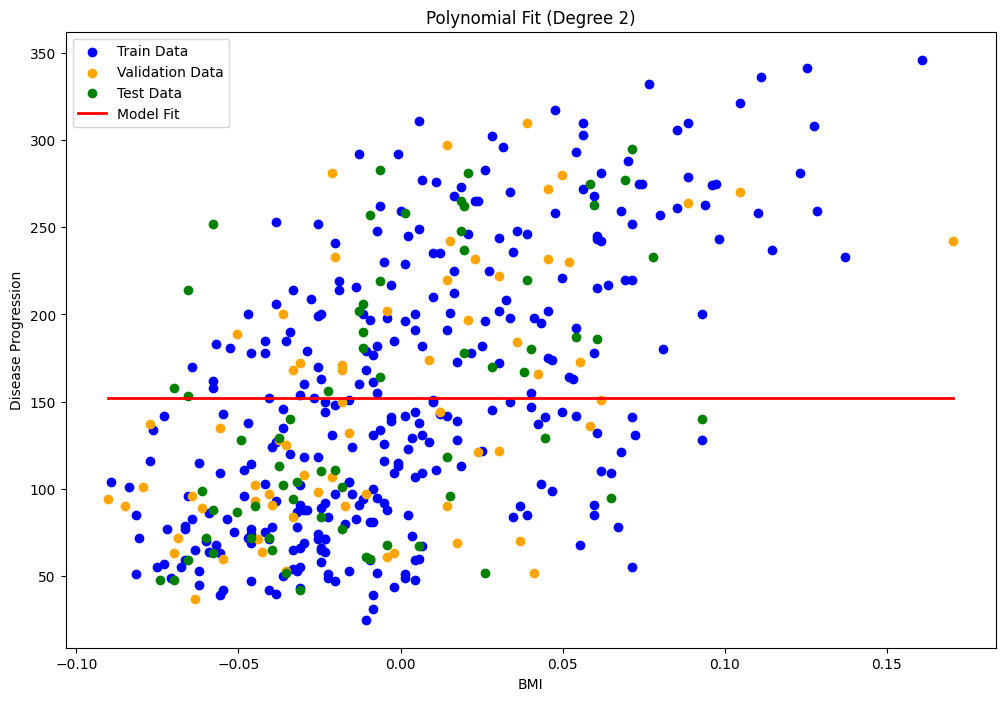

In [109]:
chosen_degree = 2 
poly = PolynomialFeatures(degree=chosen_degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

model1 = LinearRegression()
model1.fit(X_poly_train, y_train)

plt.figure(figsize=(12, 8))
plt.scatter(X_train['bmi'], y_train, color='blue', label='Train Data')
plt.scatter(X_val['bmi'], y_val, color='orange', label='Validation Data')
plt.scatter(X_test['bmi'], y_test, color='green', label='Test Data')


bmi_range = np.linspace(X['bmi'].min(), X['bmi'].max(), 100).reshape(-1, 1)
constant_features = X.mean().drop('bmi').values.reshape(1, -1)


X_plot = np.hstack((bmi_range, np.tile(constant_features, (100, 1)))) # Create a dataset with the BMI values and constant means for other features
X_plot_poly_lin = poly.transform(X_plot)
y_fit = model1.predict(X_plot_poly_lin)
plt.plot(bmi_range, y_fit, color='red', label='Model Fit', linewidth=2)

plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title(f'Polynomial Fit (Degree {chosen_degree})')
plt.legend()
plt.show()

The red line represents a quadratic (degree 2) polynomial fit. A polynomial of degree 2 is expected to form a parabolic shape, but in this case, the curve is mostly flat, indicating that the model is not capturing a significant relationship between BMI and disease progression in the range of the data.

In [69]:
coefficients = model.coef_
intercept = model.intercept_

terms = [f"{coeff:.2f}*x^{i}" for i, coeff in enumerate(coefficients)]
equation = " + ".join(terms)
equation = f"y = {intercept:.2f} + " + equation
print(equation)

y = 0.00 + 0.00*x^0 + 0.00*x^1 + 0.00*x^2 + 0.00*x^3 + 0.00*x^4 + 1.00*x^5 + 0.00*x^6 + 0.00*x^7 + -0.00*x^8 + -0.00*x^9 + -0.00*x^10 + 0.00*x^11 + 0.00*x^12 + -0.00*x^13 + -0.00*x^14 + 0.00*x^15 + 0.00*x^16 + -0.00*x^17 + 0.00*x^18 + -0.00*x^19 + 0.00*x^20


We have such a big equation is because our ploynomial transformation is applied to multiple features rather than a single feature.

In [74]:
poly2 = PolynomialFeatures(degree=2)
X_poly_train2 = poly2.fit_transform(X_train)
feature_names2 = poly2.get_feature_names_out(X_train.columns)

print(f"Number of features for degree 2: {len(feature_names2)}")
print(f"Features for degree 2: {feature_names2}")

Number of features for degree 2: 21
Features for degree 2: ['1' 'age' 'sex' 'bmi' 'bp' 'target' 'age^2' 'age sex' 'age bmi' 'age bp'
 'age target' 'sex^2' 'sex bmi' 'sex bp' 'sex target' 'bmi^2' 'bmi bp'
 'bmi target' 'bp^2' 'bp target' 'target^2']


# Conclusion for the Polynomial Regression Model:
The polynomial regression model was built to predict diabetes progression based on various features, focusing particularly on the relationship between BMI and disease progression. After evaluating models of degree 2 and degree 3, the degree 2 polynomial was selected as the best model based on its validation performance.

# Decision Tree

In [44]:
chosen2 = tree_results_df.loc[tree_results_df['R2_Val'].idxmax(), 'Max Depth']
model = DecisionTreeRegressor(max_depth=int(chosen2))
model.fit(X_train, y_train)  # Fit the model on the training data

y_test_pred = model.predict(X_test)  # Making predictions on the test set

# Calculate evaluation metrics
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test Results for max depth {chosen2} - R2: {r2_test}, MAE: {mae_test}, MAPE: {mape_test}")


Test Results for max depth 5 - R2: 0.9983958951979162, MAE: 2.541921884086062, MAPE: 0.022868366301083253


The r2 value of 0.9984 indicates that the model explains about 99.84% of the variance in the target variable.The MAE of 2.5419 indicates that, on average, the model's predictions are off by about 2.54 units from the actual values.The MAPE of approximately 0.0229 (or 2.29%) means that the predictions deviate from the actual values by an average of 2.29%.

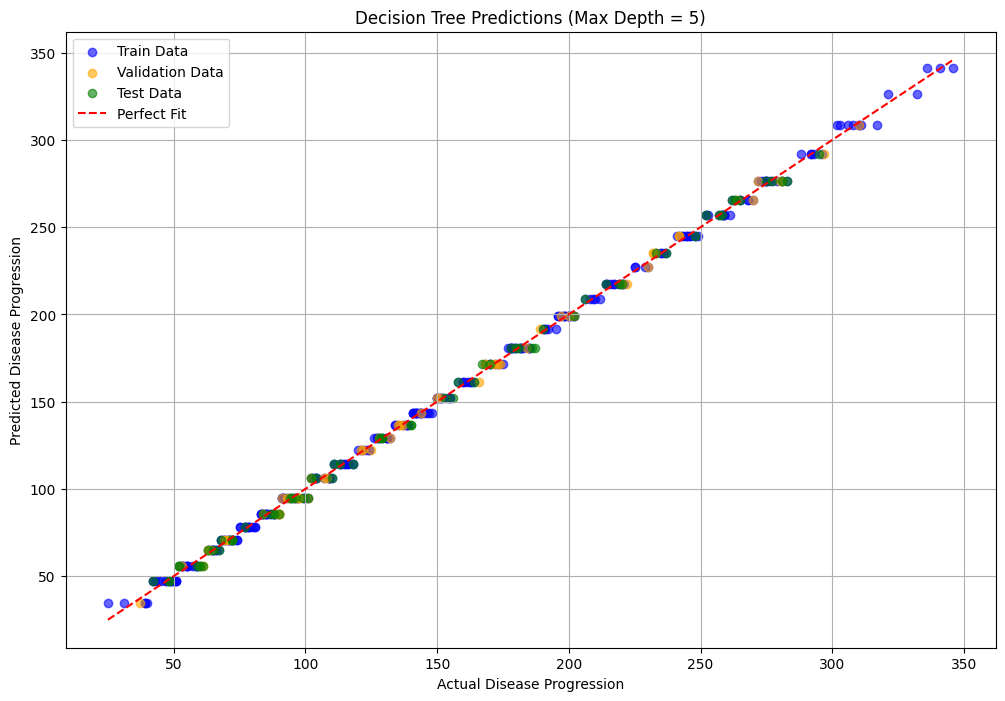

In [79]:
chosen_depth = 5 
model = DecisionTreeRegressor(max_depth=chosen_depth)
model.fit(X_train, y_train)


y_test_pred = model.predict(X_test)

plt.figure(figsize=(12, 8))
plt.scatter(y_train, model.predict(X_train), color='blue', label='Train Data', alpha=0.6)
plt.scatter(y_val, model.predict(X_val), color='orange', label='Validation Data', alpha=0.6)
plt.scatter(y_test, y_test_pred, color='green', label='Test Data', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Disease Progression')
plt.ylabel('Predicted Disease Progression')
plt.title(f'Decision Tree Predictions (Max Depth = {chosen_depth})')
plt.legend()
plt.grid(True)
plt.show()

Since X has multiple features, a direct plot of a single feature vs the target is not meaningful for the decision tree model. Most of the points across all datasets (training, validation, and test) fall very close to the red dashed line, indicating that the model's predictions are nearly identical to the actual values for disease progression.

In [85]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
tree = model.tree_
num_internal_nodes = tree.node_count - sum(tree.children_left == -1)
num_leaf_nodes = sum(tree.children_left == -1)
total_parameters = num_internal_nodes + num_leaf_nodes

print(f"Number of internal nodes (splits): {num_internal_nodes}")
print(f"Number of leaf nodes: {num_leaf_nodes}")
print(f"Total number of trainable parameters (splits + leaf nodes): {total_parameters}")

Number of internal nodes (splits): 31
Number of leaf nodes: 32
Total number of trainable parameters (splits + leaf nodes): 63


# Conclusion for the Decision Tree Regressor Model:
The Decision Tree Regressor model, with a maximum depth of 5, featuring 31 internal nodes (splits) and 32 leaf nodes, resulting in a total of 63 trainable parameters. TThe model fits well across all three datasets (train, validation, and test), and its predictions are highly accurate, as evidenced by the close alignment with the perfect fit line.For Decision tree, there isn't a equation similar to ploynomial regression.

# KNN Model

In [36]:
chosen3 = knn_results_df.loc[knn_results_df['R2_Val'].idxmax(), 'k']
model = KNeighborsRegressor(n_neighbors=int(chosen))
model.fit(X_train, y_train)  # Fit the model on the training data

y_test_pred = model.predict(X_test)  # Making predictions on the test set

# Calculate evaluation metrics
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Test Results for k {chosen3} - R2: {r2_test}, MAE: {mae_test}, MAPE: {mape_test}")

Test Results for k 5 - R2: 0.999915252581503, MAE: 0.4955223880597011, MAPE: 0.003826354505826681


The r2 value of approximately 0.9999 indicates that the model has about 99.99% of the variance in the target variable, meaning that the model's predictions are very close to the actual values.The MAE of 0.4955 indicates that, on average, the model's predictions are off by about 0.50 units from the actual values,meaning low error means a high level of accuracy in the predictions.The MAPE of approximately 0.0038 (or 0.38%) means that the model's predictions deviate from the actual values by an average of 0.38%.

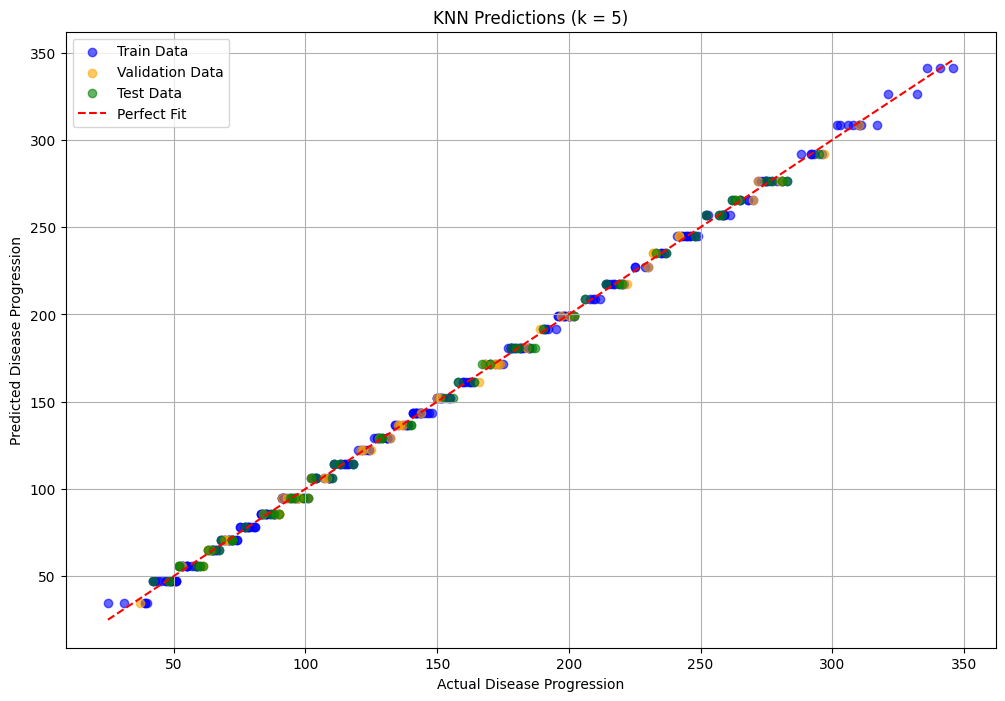

In [87]:
plt.figure(figsize=(12, 8))
plt.scatter(y_train, model.predict(X_train), color='blue', label='Train Data', alpha=0.6)
plt.scatter(y_val, model.predict(X_val), color='orange', label='Validation Data', alpha=0.6)
plt.scatter(y_test, y_test_pred, color='green', label='Test Data', alpha=0.6)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Disease Progression')
plt.ylabel('Predicted Disease Progression')
plt.title(f'KNN Predictions (k = {chosen3})')
plt.legend()
plt.grid(True)
plt.show()


Our KNN plot looks similar to decision tree plot, most of the data points across the training, validation, and test sets align closely with the perfect fit line, suggesting that the KNN model is making accurate predictions.There are a few points where the predictions for the training set deviate from the actual values, particularly at the lower end (around disease progression of 50). This might indicate that the model slightly struggles with more extreme or less frequent casess.

# Conclusion for the K-Nearest Neighbors (KNN) Model:
The KNN model with k=5 performed well in predicting diabetes progression, as demonstrated by the close alignment of predicted and actual values across training, validation, and test datasets. The model effectively generalized to unseen data, showing no clear signs of overfitting. Most predictions closely match the perfect fit line, indicating accurate performance.Unlike ploynomial regression and decision tree model, there are no explicit trainable parameters like weights or coefficients for KNN. Instead, the model "stores" the entire training dataset and uses it to find the nearest neighbors for prediction.K-Nearest Neighbors (KNN) is a non-parametric model, meaning it does not have an explicit equation like linear or polynomial regression